<a href="https://colab.research.google.com/github/beaten-by-the-market/dart_disclosure/blob/main/kospi_dart_buyback.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 코스피 상장사들의 자기주식 취득/처분결정 현황은 어떻게 될까?

✅ **배경-자사주 취득/처분방법**

자사주는 장내(거래소) 및 장외에서 취득/처분이 가능하다.

**(장내)** 장내에서 취득/처분하는 경우, 회사는 거래소에 사전에 신고해야만 한다. 이는 장내에서 자사주를 취득할 경우, 회사의 주가에 영향을 줄 수 있기 때문이다.

**(장외)** 장외의 경우, 시장에서 매매하는 것이 아니라서 주가에 영향을 주지는 않는다. 한편, 장외의 예시로는 공개매수, 증여, 계좌대체 등이 있다.(시간외대량매매는 장내로 구분)  
</br>

✅ **배경-자사주 관련 금감원 서식**

자기주식 취득은 자본시장법에 따라 금감원 공시(주요사항보고서)로 제출한다.

**(수량)** 금감원 공시는 이사회에서 '결의'한 시점에 제출된 공시이므로, 취득**'예정'** 수량/금액이다. 따라서 실제 취득은 결의한 수량/금액보다 적을 수 있다.
</br>

**(결과보고)** 자기주식 취득이 완료되면 자기주식 취득결과 보고서를 금감원 공시로 제출한다. 하지만 주요사항보고서는 OpenDart에서 서비스하는 반면, **결과보고서는 OpenDart에서 서비스하지 않는다.**

</br>

✅ **배경-자사주 관련 거래소 신고**

자기주식 취득을 위해 장내에서 주문 제출하기 전에 상장법인은 거래소에 사전에 신고해야 하고, 주문호가에 자사주 매매에 관한 내용이 태깅된다.

이는 자본시장법 위반을 방지하기 위한 모니터링수단이다. 한편 그러나 한국거래소는 시장을 운영하는 주식회사로, **장외** 취득/처분 수량은 거래소 시스템에 신고되지 않는다. 즉, **장외** 수량은 **금감원 서식(결정공시 및 결과보고서)**으로만 확인이 가능하다.

</br>

___
😮 **데이터의 출처(금감원, 한국거래소)에 따라 각각의 한계가 존재하는데, 이러한 점을 고려하여 "코스피 상장사들의 자기주식 취득/처분결정 현황은 어떻게 될까?"를 알아보기로 하자!**

___

</br>

**※ 데이터 수집 및 시각화 방향**

**1. OpenDART를 통해 자기주식 관련 금감원 공시 내용 수집하기**
전체 자사주 **"직접"** 취득/처분하기로 **결정한** 수량의 추이를 확인

**2. 금감원 공시에서 자사주 매매의 장내/장외를 구분하기**
장내 수량이 얼마나 많을까? 만약 생각보다 장외수량이 미미하다면 거래소 데이터 활용 가능할 것이다!

**3. (참고)장내 자사주 매매 관련 데이터를 거래소에서 취득**
**'장내'**  자사주 매매 결정 대비 체결 수량 추이를 확인




### 코랩 환경에서 데이터 수집, 시각화를 하기 위해 필요한 라이브러리를 설치

In [ ]:
# 필요한 라이브러리 설치
import pandas as pd
import requests
from io import BytesIO, StringIO
from time import sleep
from tqdm import tqdm
from bs4 import BeautifulSoup
import json
import re
import numpy as np
from datetime import datetime

# 시각화 관련
!pip install adjustText
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from adjustText import adjust_text

# 한글 폰트 설정 (Google Colab 환경에서)
!apt-get update -qq
!apt-get install fonts-nanum* -qq

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 124565 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Setting up fo

### 금감원 공시에서 자사주 데이터 수집하기

1. 금감원 공시를 통해 자사주 직접 **취득** 통계 불러오기

배경에서도 설명했지만, 주요사항보고서(자사주취득) 공시기준 데이터이기 때문에, 실제 취득수량과는 차이가 있다.

검색 기준은 "유가", "2015~2024"년으로 한다. **OpenDart는 2015년부터 데이터를 제공**한다.

📓 **OpenDart API를 사용하는 것이 아닌, OpenDart 웹페이지를 크롤링 해오는 방식으로 데이터를 수집하였다. POST 방식으로 수집하는 이 방법은 별도의 글로 작성할 예정이다.**

In [ ]:
# 사용자 입력 받기
start_y = "2015"
end_y = "2024"
corp_type_input = "유"

# 기본 params 템플릿
params = {
    "pageIndex": "1",
    "pageSize": "10",
    "pageUnit": "10",
    "recordCountPerPage": "1000",
    "sortStdr": "crp",
    "sortOrdr": "asc",
    "sumSortStdr": "",
    "sumSortOrdr": "asc",
    "textCrpCik": "",
    "bgnDe": f"{start_y}-01-01",
    "endDe": f"{end_y}-12-31",
    "textCrpNm": "",
    "startDate": f"{start_y}-01-01",
    "endDate": f"{end_y}-12-31",
    "reportCode": "11332" #직접취득 11332, 직접처분 11333, 신탁취득 11334, 신탁해지 11335
}

# corpType 설정
corp_type_map = {
    "유": "P",
    "코": "A",
    "유코": ["P", "A"]
}

if corp_type_input in corp_type_map:
    params["corpType"] = corp_type_map[corp_type_input]
else:
    print('잘못된 입력입니다. 재실행하세요')

# 결과 출력
params

{'pageIndex': '1',
 'pageSize': '10',
 'pageUnit': '10',
 'recordCountPerPage': '1000',
 'sortStdr': 'crp',
 'sortOrdr': 'asc',
 'sumSortStdr': '',
 'sumSortOrdr': 'asc',
 'textCrpCik': '',
 'bgnDe': '2015-01-01',
 'endDe': '2024-12-31',
 'textCrpNm': '',
 'startDate': '2015-01-01',
 'endDate': '2024-12-31',
 'reportCode': '11332',
 'corpType': 'P'}

처음 크롤링은 페이지 인덱스 1을 기준으로 한다. 첫번째 페이지를 크롤링 했을 때, 그 결과물에는 전체 페이지가 얼마나 되는지 정보가 포함되어 있다. 따라서 첫번째 페이지 크롤링 결과물에서 페이지가 2이상인 것으로 확인되는 경우 추가로 크롤링을 수행한다.

우선 첫번째 페이지의 크롤링을 수행한다.

In [ ]:
# 첫번째 페이지를 기준으로 크롤링
url = 'https://opendart.fss.or.kr/disclosureinfo/mainMatter/list.do'
req = requests.post(url, params = params)

# 데이터를 수집할 빈 데이터프레임 생성
df_dart_buyback = pd.DataFrame()

# 데이터프레임 파싱
content = req.content.decode('utf-8')
html_string = StringIO(content)  # StringIO로 HTML 문자열 감싸기
df_loop = pd.read_html(html_string)[0]

#데이터프레임 합치기
df_dart_buyback = pd.concat([df_dart_buyback, df_loop])

첫번째 페이지의 크롤링 결과물에서 전체 페이지 수를 확인하고, 페이지가 2이상일 경우 페이지 수만큼 Loop을 통해 크롤링 수행한다.

In [ ]:
# beautifulsoup 객체로 전환
soup = BeautifulSoup(content, 'html.parser')

# 끝에서 두번째 div 태그에 페이지 정보가 있음
output_string = soup.find_all('div')[-2].text

import re

# 정규 표현식을 사용하여 숫자 추출
match = re.match(r"\[(\d+)/(\d+)\] \[총 (\d+)건\]", output_string)

if match:
    total_page = int(match.group(2))
    total_counts = int(match.group(3))
    print(f"total_page: {total_page}")
    print(f"total_counts: {total_counts}")
else:
    print("출력물 형식이 올바르지 않습니다.")

for i in range(2, total_page + 1):
  page_index = str(i)
  # params 기준에서 페이지 인덱스만 수정하기
  params["pageIndex"] = page_index

  req = requests.post(url, params = params)
  content = req.content.decode('utf-8')
  html_string = StringIO(content)  # StringIO로 HTML 문자열 감싸기
  df_loop = pd.read_html(html_string)[0]

  # IP차단을 위해 쉬어가기
  sleep(1)

  #데이터프레임 합치기
  df_dart_buyback = pd.concat([df_dart_buyback, df_loop])

total_page: 7
total_counts: 649


데이터를 모두 수집하여 데이터프레임으로 만들었다. 다운받은 데이터프레임의 칼럼이 현재 3단계로 되어있는데, 분석의 편의성을 위해 칼럼을 1단계로 축소하고 단위를 변환(원 → 억원)한다.

In [ ]:
# 멀티인덱스를 1단계로 변환 (문자열 변환 추가)
df_dart_buyback.columns = ['_'.join(map(str, filter(None, col))) for col in df_dart_buyback.columns]

# 접수일을 datetime으로 변환 및 연도 추출
df_dart_buyback['접수일_접수일_접수일'] = pd.to_datetime(df_dart_buyback['접수일_접수일_접수일'])
df_dart_buyback['연도'] = df_dart_buyback['접수일_접수일_접수일'].dt.year

# 데이터 타입 변경
df_dart_buyback['연도'] = pd.to_numeric(df_dart_buyback['연도'], errors='coerce').astype('Int64')

df_dart_buyback['취득예정주식(주)_취득예정주식(주)_보통주식'] = pd.to_numeric(
    df_dart_buyback['취득예정주식(주)_취득예정주식(주)_보통주식'], errors='coerce').fillna(0)

df_dart_buyback['취득예정금액(원)_취득예정금액(원)_보통주식'] = pd.to_numeric(
    df_dart_buyback['취득예정금액(원)_취득예정금액(원)_보통주식'], errors='coerce').fillna(0) / 1e8  # 원 -> 억 원 변환

#### 금감원 공시 기준 데이터 시각화

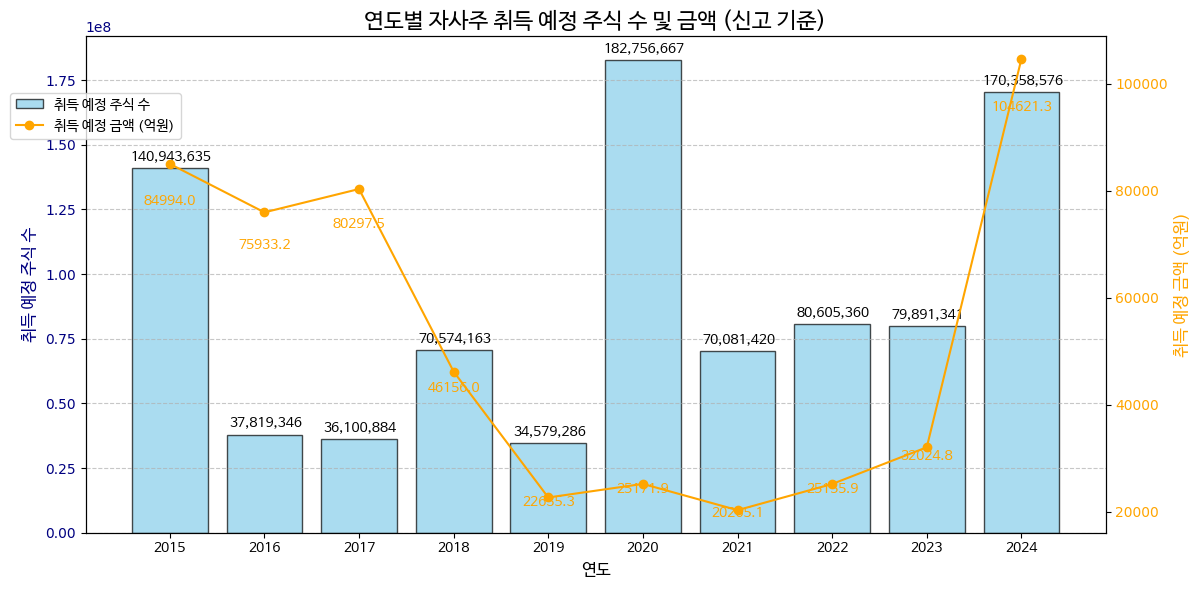

In [ ]:
# 연도별 취득예정주식(주) 및 취득예정금액 집계
annual_summary = df_dart_buyback.groupby('연도').agg({
    '취득예정주식(주)_취득예정주식(주)_보통주식': 'sum',
    '취득예정금액(원)_취득예정금액(원)_보통주식': 'sum'
})

# 그래프 크기 설정
fig, ax1 = plt.subplots(figsize=(12, 6))

# 막대 그래프: 연도별 취득 예정 주식 수
bars = ax1.bar(annual_summary.index,
               annual_summary['취득예정주식(주)_취득예정주식(주)_보통주식'],
               color='skyblue', edgecolor='black', alpha=0.7, label='취득 예정 주식 수')
ax1.set_xlabel('연도', fontproperties=font, fontsize=12)
ax1.set_ylabel('취득 예정 주식 수', fontproperties=font, fontsize=12, color='navy')
ax1.tick_params(axis='y', labelcolor='navy')

# x축 눈금 설정 (모든 연도 표시)
plt.xticks(annual_summary.index, fontproperties=font, fontsize=10)

# 데이터 라벨 추가 (막대 그래프)
texts = []
for bar in bars:
    height = bar.get_height()
    if height > 0:  # 데이터가 있는 경우에만 레이블 추가
        texts.append(ax1.text(bar.get_x() + bar.get_width() / 2., height,
                              f'{height:,.0f}', ha='center', va='bottom',
                              fontproperties=font, fontsize=10))

# 보조축 추가: 취득 예정 금액
ax2 = ax1.twinx()
line, = ax2.plot(annual_summary.index,
                 annual_summary['취득예정금액(원)_취득예정금액(원)_보통주식'],
                 color='orange', marker='o', label='취득 예정 금액 (억원)')
ax2.set_ylabel('취득 예정 금액 (억원)', fontproperties=font, fontsize=12, color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 선 그래프 레이블 추가
for i, value in enumerate(annual_summary['취득예정금액(원)_취득예정금액(원)_보통주식']):
    ax2.text(annual_summary.index[i], value*0.9, f'{value:.1f}',
             color='orange', fontsize=10, ha='center', va='bottom', fontproperties=font)

# adjustText를 사용하여 레이블 위치 조정
adjust_text(texts, ax=ax1)

# y축 그리드 추가
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# 범례 추가
fig.legend(loc='upper right', bbox_to_anchor=(0.1, 0.9), bbox_transform=ax1.transAxes, prop=font)

# 그래프 제목 설정
plt.title('연도별 자사주 취득 예정 주식 수 및 금액 (신고 기준)', fontproperties=font, fontsize=16)

# 그래프 여백 조정
plt.tight_layout()

# 그래프 표시
plt.show()


#### 금감원 공시에서 장내 vs 장외 구분자 달기

In [ ]:
# 정규식 패턴 정의
pattern_mkt = re.compile(r'시장|장내|시간\s?외|거래소')  # '시간 외'와 '시간외'를 모두 포함
pattern_otc_exclude = re.compile(r'시장\s?외')  # '시장 외'와 '시장외'를 모두 포함

# method 열 생성
def categorize_method(method):
    if pattern_mkt.search(method) and not pattern_otc_exclude.search(method):
        return 'mkt'
    else:
        return 'otc'

# 새로운 열에 카테고리 할당
df_dart_buyback['method'] = df_dart_buyback['취득방법_취득방법_취득방법'].apply(categorize_method)

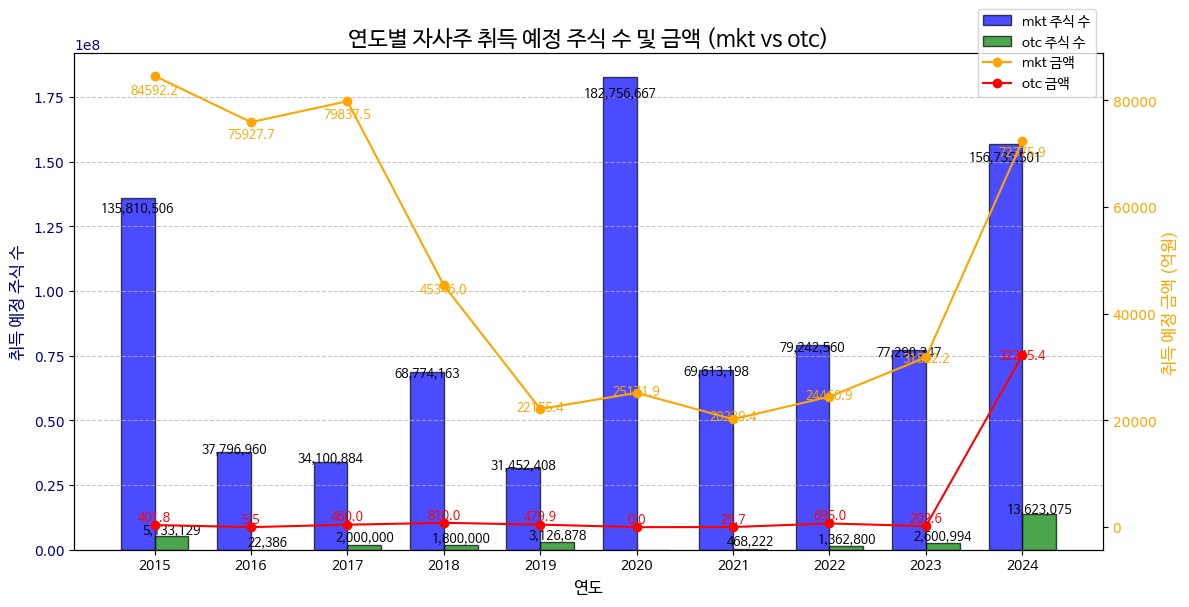

In [ ]:
# 연도별 mkt, otc로 나눈 집계
annual_summary = df_dart_buyback.groupby(['연도', 'method']).agg({
    '취득예정주식(주)_취득예정주식(주)_보통주식': 'sum',
    '취득예정금액(원)_취득예정금액(원)_보통주식': 'sum'
}).reset_index()

# 연도별로 mkt와 otc로 나눠서 데이터 생성
mkt_summary = annual_summary[annual_summary['method'] == 'mkt']
otc_summary = annual_summary[annual_summary['method'] == 'otc']

# 그래프 크기 설정
fig, ax1 = plt.subplots(figsize=(12, 6))

# 막대 그래프: mkt와 otc 별로 색상 다르게 표시
bar_width = 0.35  # 막대 폭
indices = mkt_summary['연도']  # x축 연도 값
bars_mkt = ax1.bar(indices - bar_width / 2,
                   mkt_summary['취득예정주식(주)_취득예정주식(주)_보통주식'],
                   color='blue', edgecolor='black', alpha=0.7, label='mkt 주식 수', width=bar_width)

bars_otc = ax1.bar(indices + bar_width / 2,
                   otc_summary['취득예정주식(주)_취득예정주식(주)_보통주식'],
                   color='green', edgecolor='black', alpha=0.7, label='otc 주식 수', width=bar_width)

# 축 라벨 및 눈금 설정
ax1.set_xlabel('연도', fontproperties=font, fontsize=12)
ax1.set_ylabel('취득 예정 주식 수', fontproperties=font, fontsize=12, color='navy')
ax1.tick_params(axis='y', labelcolor='navy')
plt.xticks(indices, fontproperties=font, fontsize=10)

# 보조축 추가: mkt와 otc의 라인 그래프
ax2 = ax1.twinx()

line_mkt, = ax2.plot(mkt_summary['연도'],
                     mkt_summary['취득예정금액(원)_취득예정금액(원)_보통주식'] ,
                     color='orange', marker='o', label='mkt 금액')

line_otc, = ax2.plot(otc_summary['연도'],
                     otc_summary['취득예정금액(원)_취득예정금액(원)_보통주식'] ,
                     color='red', marker='o', label='otc 금액')

ax2.set_ylabel('취득 예정 금액 (억원)', fontproperties=font, fontsize=12, color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 데이터 라벨 추가 (막대 및 라인 그래프)
for bar in bars_mkt:
    height = bar.get_height()
    if height > 0:
        ax1.text(bar.get_x() + bar.get_width() / 2, height * 0.95,
                 f'{height:,.0f}', ha='center', va='bottom',
                 fontproperties=font, fontsize=9)

for bar in bars_otc:
    height = bar.get_height()
    if height > 0:
        ax1.text(bar.get_x() + bar.get_width() / 2, height * 0.95,
                 f'{height:,.0f}', ha='center', va='bottom',
                 fontproperties=font, fontsize=9)

for i, value in enumerate(mkt_summary['취득예정금액(원)_취득예정금액(원)_보통주식'] ):
    ax2.text(mkt_summary['연도'].iloc[i], value * 0.95,
             f'{value:.1f}', color='orange', fontsize=9,
             ha='center', va='bottom', fontproperties=font)

for i, value in enumerate(otc_summary['취득예정금액(원)_취득예정금액(원)_보통주식'] ):
    ax2.text(otc_summary['연도'].iloc[i], value * 0.95,
             f'{value:.1f}', color='red', fontsize=9,
             ha='center', va='bottom', fontproperties=font)

# y축 그리드 추가
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# 범례 추가
fig.legend(loc='right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes, prop=font)

# 그래프 제목 설정
plt.title('연도별 자사주 취득 예정 주식 수 및 금액 (mkt vs otc)', fontproperties=font, fontsize=16)

# 그래프 여백 조정
plt.tight_layout()

# 그래프 표시
plt.show()

전반적으로 장외취득은 미미한 수준이나, 2024년에 유의미하게 높았다. 2024년 데이터를 확인해보니, 고려아연에서 발생한 경영권분쟁 관련 공개매수에 의한 것이었다. 이러한 특수한 경우를 제외하고는 "이사회 결정기준" 장외 취득의 비중은 대세에는 영향을 미치지 않는 것으로 확인되었다.

In [ ]:
# 2024년 내역 확인
df_show = df_dart_buyback[df_dart_buyback['연도']==2024].sort_values(by='취득예정금액(원)_취득예정금액(원)_보통주식', ascending=False)

#필요한 칼럼만 남기기
df_show = df_show[['회사명_회사명_회사명', '접수일_접수일_접수일', '취득예정주식(주)_취득예정주식(주)_보통주식', '취득예정금액(원)_취득예정금액(원)_보통주식', '연도', 'method']]

#칼럼명 수정
df_show.columns = ['회사명', '접수일', '취득예정주식(주)', '취득예정금액(억원)', '연도', 'method']

# HTML 변환 및 커스텀 태그로 감싸기
html_table = df_show.to_html(index=False, classes="dataframe", escape=False)

# 테이블을 <div> 태그로 감싸기
wrapped_html = f"""
<div class="table-container">
  {html_table}
</div>
"""
print(html_table)

<table border="1" class="dataframe dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>회사명</th>
      <th>접수일</th>
      <th>취득예정주식(주)</th>
      <th>취득예정금액(억원)</th>
      <th>연도</th>
      <th>method</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>유고려아연</td>
      <td>2024-10-11</td>
      <td>3623075.0</td>
      <td>32245.367500</td>
      <td>2024</td>
      <td>otc</td>
    </tr>
    <tr>
      <td>유삼성전자</td>
      <td>2024-11-18</td>
      <td>50144628.0</td>
      <td>26827.375980</td>
      <td>2024</td>
      <td>mkt</td>
    </tr>
    <tr>
      <td>유현대자동차</td>
      <td>2024-11-27</td>
      <td>3906545.0</td>
      <td>8731.128075</td>
      <td>2024</td>
      <td>mkt</td>
    </tr>
    <tr>
      <td>유기아</td>
      <td>2024-01-25</td>
      <td>5688282.0</td>
      <td>5000.000000</td>
      <td>2024</td>
      <td>mkt</td>
    </tr>
    <tr>
      <td>유NAVER  IR</td>
      <td>2024-09-30</td>
      <td>2347500.0</td>
      <td>4011.877500</td>
    